## Brain State Classification Using SVM 

In [1]:
import nibabel as nib
import nilearn
from nilearn import image

import sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.svm import SVC
import scipy.io as sio

import matplotlib.pyplot as plt
import numpy as np
import cv2

/anaconda2/envs/Python36/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


# Test Images

### Import Brain Test Images

In [2]:
test_img_fname = './sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii'

In [3]:
test_img=[]
for volume in image.iter_img(test_img_fname):
    test_img.append(volume.dataobj)

In [4]:
test_img=np.array(test_img)

In [5]:
test_img.shape

(184, 64, 64, 30)

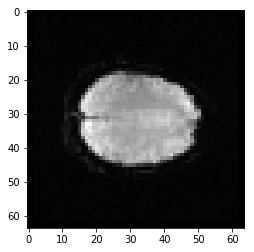

In [6]:
plt.imshow(test_img[1,:,:,20],cmap='gray')

### Test Image Mask

In [7]:
test_mask_fname = './sub-01/ses-test/func/c6rsub-01_ses-test_task-fingerfootlips_bold.nii'

In [8]:
test_mask_fname = nib.load(test_mask_fname)

In [9]:
test_mask_fname.shape

(64, 64, 30)

In [10]:
test_mask_arr = test_mask_fname.get_fdata()

In [11]:
#create a binary mask using thresholding
thresh,test_binary_mask = cv2.threshold(test_mask_fname.get_fdata(),0.9,1,cv2.THRESH_BINARY_INV)

(64, 64, 30)


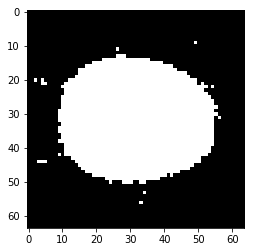

In [12]:
print(test_binary_mask.shape)
plt.imshow(test_binary_mask[:,:,20],cmap='gray')

### Test Images Masking

In [13]:
test_img.shape

(184, 64, 64, 30)

In [14]:
#convolution on test images using the mask image
test_masked_img=[]
for i in range(184):
    ar3=[]
    for j in range(64):
        ar2=[]
        for k in range(64):
            ar1=[]
            for l in range(30):
                ar1.append(test_img[i][j][k][l]*test_binary_mask[j][k][l])
            ar2.append(ar1)
        ar3.append(ar2)
    test_masked_img.append(ar3)

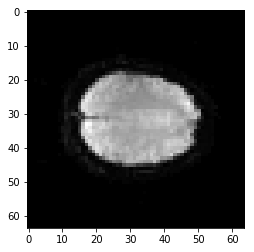

In [15]:
test_masked_img=np.array(test_masked_img)
plt.imshow(test_masked_img[1,:,:,20],cmap='gray')
#print(test_masked_img)

### Test Images Feature Extraction

In [16]:
test_reshaped_arr=[]
print(test_masked_img.shape)
test_reshaped_arr = test_masked_img.reshape(184,122880)

(184, 64, 64, 30)


In [17]:
test_reshaped_arr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
test_reshaped_arr.shape

(184, 122880)

### Test Images PCA

In [19]:
#fit the PCA model on training data with n components
components = 85
sklearn_pca = PCA(n_components=components)
sklearn_pca.fit(test_reshaped_arr)

PCA(copy=True, iterated_power='auto', n_components=85, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [20]:
#transform
test_reduced_train=[]
test_reduced_train = sklearn_pca.transform(test_reshaped_arr)

In [21]:
test_reduced_train.shape

(184, 85)

### Test Images SVM

In [22]:
#creating the array of labels
labels = sio.loadmat('label.mat')
test_conditions=[]
test_conditions=labels['label']
test_label_new = dict(enumerate(labels['label'].flatten(), 1))

test_conditions_new = []
for c in test_conditions:
    test_conditions_new.append(c[0])

In [26]:
#creating a model for the classifier
svc = SVC(kernel='linear',gamma='auto')

In [27]:
#fitting the classifier
svc.fit(test_reduced_train,test_conditions_new)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [28]:
#predicting with the training set
prediction = svc.predict(test_reduced_train)
#accuracy should be 1, because it is predicted using the training set
print((prediction == test_conditions_new).sum() / float(len(test_conditions_new)))

1.0


### KFold Cross Validation

### Hyperparameter tuning

In [29]:
import sklearn
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import math

In [30]:
svm = SVC()
hyperparams = {'kernel':['linear','poly','rbf','sigmoid'],
               'gamma' : [math.pow(2,i) for i in range(-15,3,2)],
               'C' : [math.pow(2,i) for i in range(-5,15,2)],
              }

cross_validation = StratifiedKFold(n_splits=11)
grid_search = GridSearchCV(svm,param_grid=hyperparams,cv=cross_validation)

grid_search.fit(test_reduced_train, test_conditions_new)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

print(grid_search.best_estimator_)

Best score: 0.8152173913043478
Best parameters: {'C': 0.03125, 'gamma': 3.0517578125e-05, 'kernel': 'linear'}
SVC(C=0.03125, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=3.0517578125e-05,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


/anaconda2/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Test Images With PCA

In [31]:
from sklearn.model_selection import cross_val_score
np.mean(cross_val_score(svc,test_reshaped_arr,test_conditions_new,cv=19))

0.8381749829118251

In [32]:
#implementing K-fold cross validation
#creating 19 splits of training and testing data sets

cv = StratifiedKFold(n_splits=19, random_state=None, shuffle=False)
accuracy=[]
ac1=[]
for train, test in cv.split(X=test_reduced_train,y=test_conditions_new):
    
    conditions_masked = [test_conditions_new[i] for i in train]
  
    #training the classifier with the training part of the data
    svc.fit([test_reduced_train[i] for i in train], conditions_masked)
    
    #testing withe the testing portion of the data
    prediction = svc.predict([test_reduced_train[i] for i in test])
    
    j=0
    #ac1.append(svc.score([test_reduced_train[i] for i in test],[test_conditions_new[i] for i in test]))
    pred_match=[]
    
    #getting count of correctly matched labels
    for i in test:
        pred_match.append(prediction[j] == test_conditions_new[i])
        j+=1
            
    pred_match = np.array(pred_match)
    accuracy.append(pred_match.sum() / float(len(pred_match)))
    
print(np.mean(accuracy))
#print(np.mean(ac1))

0.8726076555023923


### Test Images Without PCA

In [33]:
#implementing K-fold cross validation
#creating 19 splits of training and testing data sets

cv = StratifiedKFold(n_splits=19, random_state=None, shuffle=False)
accuracy=[]
for train, test in cv.split(X=test_reshaped_arr,y=test_conditions_new):
    
    conditions_masked = [test_conditions_new[i] for i in train]
    
    #training the classifier with the training part of the data
    svc.fit([test_reshaped_arr[i] for i in train], conditions_masked)
    
    #testing withe the testing portion of the data
    prediction = svc.predict([test_reshaped_arr[i] for i in test])
    
    j=0
    pred_match=[]
    
    #getting count of correctly matched labels
    for i in test:
        pred_match.append(prediction[j] == test_conditions_new[i])
        j+=1
            
    pred_match = np.array(pred_match)
    accuracy.append(pred_match.sum() / float(len(pred_match)))
print(np.mean(accuracy))

0.8381749829118251


# Retest Images

### Import Brain Retest Images

In [34]:
retest_img_fname = './sub-01/ses-retest/func/sub-01_ses-retest_task-fingerfootlips_bold.nii'

In [35]:
retest_img=[]
for volume in image.iter_img(retest_img_fname):
    retest_img.append(volume.dataobj)

In [36]:
retest_img=np.array(retest_img)

In [37]:
retest_img.shape

(184, 64, 64, 30)

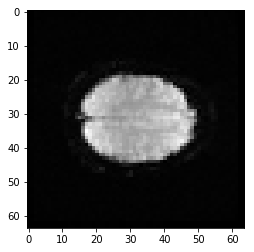

In [38]:
plt.imshow(retest_img[1,:,:,20],cmap='gray')

### Retest Image Mask

In [39]:
retest_mask_fname = './sub-01/ses-retest/func/c6rsub-01_ses-retest_task-fingerfootlips_bold.nii'

In [40]:
retest_mask_img = nib.load(retest_mask_fname)

In [41]:
retest_mask_img.shape

(64, 64, 30)

In [42]:
retest_mask_arr = retest_mask_img.get_fdata()

In [43]:
#create a binary mask using thresholding
thresh,retest_binary_mask = cv2.threshold(retest_mask_img.get_fdata(),0.8,1,cv2.THRESH_BINARY_INV)

(64, 64, 30)


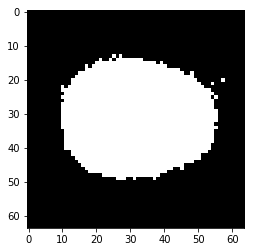

In [44]:
print(retest_binary_mask.shape)
plt.imshow(retest_binary_mask[:,:,20],cmap='gray')

### Retest Images Masking

In [45]:
retest_img.shape

(184, 64, 64, 30)

In [46]:
#convolution on retest images using the mask image
retest_masked_img=[]
for i in range(184):
    ar3=[]
    for j in range(64):
        ar2=[]
        for k in range(64):
            ar1=[]
            for l in range(30):
                ar1.append(retest_img[i][j][k][l]*retest_binary_mask[j][k][l])
            ar2.append(ar1)
        ar3.append(ar2)
    retest_masked_img.append(ar3)

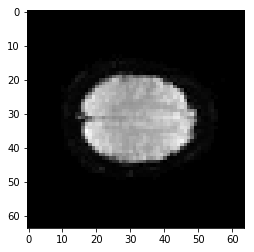

In [47]:
retest_masked_img=np.array(retest_masked_img)
plt.imshow(retest_masked_img[1,:,:,20],cmap='gray')

### Retest Images Feature Extraction

In [48]:
retest_reshaped_arr=[]
print(retest_masked_img.shape)
retest_reshaped_arr = retest_masked_img.reshape(184,122880)

(184, 64, 64, 30)


In [49]:
retest_reshaped_arr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [50]:
retest_reshaped_arr.shape

(184, 122880)

### Retest Images PCA

In [51]:
#fit the PCA model on training data with n components
components = 85
sklearn_pca = PCA(n_components=components)
sklearn_pca.fit(retest_reshaped_arr)

PCA(copy=True, iterated_power='auto', n_components=85, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [52]:
#transform
retest_reduced_train=[]
retest_reduced_train = sklearn_pca.transform(retest_reshaped_arr)

In [53]:
retest_reduced_train.shape

(184, 85)

### Retest Images SVM

In [54]:
#creating a model for the classifier
retest_svc = SVC(C=1.0,kernel='linear',gamma='auto',random_state=None)
print(retest_svc)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [55]:
#creating the array of labels
labels = sio.loadmat('label.mat')
retest_conditions=[]
retest_conditions=labels['label']
retest_label_new = dict(enumerate(labels['label'].flatten(), 1))
retest_conditions_new = []
for c in retest_conditions:
    retest_conditions_new.append(c[0])

In [56]:
#fitting the classifier
retest_svc.fit(retest_reduced_train,retest_conditions_new)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [57]:
#predicting with the training set itself
prediction = retest_svc.predict(retest_reduced_train)

#accuracy should be 1, because it is predicted using the training set
print((prediction == retest_conditions_new).sum() / float(len(retest_conditions_new)))

1.0


### KFold Cross Validation

### Retest Images With PCA

In [58]:
#implementing K-fold cross validation
#creating 17 splits of training and testing data sets

cv = StratifiedKFold(n_splits=17, random_state=None, shuffle=False)
accuracy=[]
for train, test in cv.split(X=retest_reduced_train,y=retest_conditions_new):
    
    conditions_masked = [retest_conditions_new[i] for i in train]
    
    #training the classifier with the training part of the data
    retest_svc.fit([retest_reduced_train[i] for i in train], conditions_masked)
    
    #testing withe the testing portion of the data
    prediction = retest_svc.predict(retest_reduced_train[test])
    
    j=0
    pred_match=[]
    
    #getting count of correctly matched labels
    for i in test:
        pred_match.append(prediction[j] == retest_conditions_new[i])
        j+=1
            
    pred_match = np.array(pred_match)
    accuracy.append(pred_match.sum() / float(len(retest_reduced_train[test])))
print(np.mean(accuracy))

0.8139483065953653


### Retest Images Without PCA

In [59]:
#implementing K-fold cross validation
#creating 17 splits of training and testing data sets

cv = StratifiedKFold(n_splits=17, random_state=None, shuffle=False)
accuracy=[]
for train, test in cv.split(X=retest_reshaped_arr,y=retest_conditions_new):
    
    conditions_masked = [retest_conditions_new[i] for i in train]
    
    #training the classifier with the training part of the data
    retest_svc.fit([retest_reshaped_arr[i] for i in train], conditions_masked)
    
    #testing withe the testing portion of the data
    prediction = retest_svc.predict(retest_reshaped_arr[test])
    
    j=0
    pred_match=[]
    
    #getting count of correctly matched labels
    for i in test:
        pred_match.append(prediction[j] == retest_conditions_new[i])
        j+=1
            
    pred_match = np.array(pred_match)
    accuracy.append(pred_match.sum() / float(len(retest_reshaped_arr[test])))
print(np.mean(accuracy))

0.7916666666666667
